In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import kurtosis
# Bibliotecas de modelamiento
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")

In [118]:
def remove_outliers_zscore(df, column, threshold=3):
    """
    Remove rows from a DataFrame where the Z-score of the values in a given column exceeds the threshold.
    
    Parameters:
    df (pd.DataFrame): The DataFrame from which to remove outliers.
    column (str): The name of the column to check for outliers.
    threshold (float): The Z-score threshold for determining outliers. Default is 3.
    
    Returns:
    pd.DataFrame: The DataFrame with outliers removed.
    """
    # Calculate the Z-scores
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    
    # Filter the DataFrame to keep only rows where Z-score is below the threshold
    df_filtered = df[z_scores < threshold]
    
    return df_filtered

In [119]:
def cramers_v(var1, var2):
    """Calcula la correlación de Cramér V entre dos variables categóricas."""
    tabla = pd.crosstab(var1, var2)
    chi2, p, dof, expected = chi2_contingency(tabla)
    n = tabla.sum().sum()
    min_dim = min(tabla.shape) - 1
    return np.sqrt((chi2 / n) / min_dim)

def cramer_v_matrix(df):
    """Devuelve un DataFrame con la correlación de Cramér V entre todas las variables categóricas del DataFrame."""
    # Seleccionamos solo las columnas categóricas
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Creamos un DataFrame vacío para almacenar los valores de correlación
    cramers_v_df = pd.DataFrame(index=categorical_cols, columns=categorical_cols)
    
    # Rellenamos la matriz de correlaciones con los valores de Cramér V
    for col1 in categorical_cols:
        for col2 in categorical_cols:
            if col1 == col2:
                cramers_v_df.loc[col1, col2] = 1.0  # Correlación perfecta consigo misma
            else:
                cramers_v_df.loc[col1, col2] = cramers_v(df[col1], df[col2])
    
    return cramers_v_df

In [120]:
df = pd.read_excel("../trabajo_final/Data Set.xlsx")

In [121]:
df.columns = [i.lower() for i in df.columns]
df["applicant_postal_code"] = df["applicant_postal_code"].astype(str)
df = df.drop(columns=["gender_desc"])

In [122]:
df.head()

,id,requested_amount,emi_amount,age,applicant_postal_code,duration_of_current_emp,product_name1,product_line,loan_term,variant_code,...,no_of_years_in_city,no_of_years_at_business,segment_desc,cost_of_vehicle,average_bank_balance,cibil_score,disbursed,irr,max_od_f_12m,total_ntech_bnc_f12m
0,1,200000,5750.0,40.50,400091.0,5.0,CHEVROLET SPARK,CHEVROLET SPARK LT 1.0 BS-IV OBDII,48.0,LT 1.0 BS-IV OBDII,...,35.0,NaN,Compact,237342.0,NaN,594.0,No,24.70,NaN,NaN
1,2,1900000,NaN,41.25,641002.0,NaN,FORTUNER 4 WD,TOYOTA - FORTUNER 4 WD,48.0,FORTUNER 4 WD,...,1.0,NaN,SUV,2400000.0,NaN,754.0,Yes,24.70,0.0,0.0
2,3,1600000,NaN,39.50,641002.0,NaN,NaN,TOYOTA - FORTUNER 3.0 L,48.0,FORTUNER 3.0 L,...,1.0,NaN,SUV,2200000.0,NaN,779.0,Yes,16.50,0.0,0.0
3,4,300000,9050.0,35.00,390019.0,16.0,NISSAN MICRA,NISSAN MICRA,48.0,NISSAN MICRA XL,...,7.0,NaN,Compact,365750.0,NaN,818.0,Yes,18.10,0.0,0.0
4,5,250000,8750.0,34.00,390023.0,NaN,XYLO E8,XYLO E8,36.0,XYLO E8,...,2.0,NaN,MUV,548750.0,NaN,853.0,Yes,17.69,0.0,1.0


In [123]:
missing_percentage = df.isnull().mean() * 100
columns_with_nulls_above_30 = missing_percentage[missing_percentage > 30].index.tolist()
print(missing_percentage)

id                             0.000000
requested_amount               0.000000
emi_amount                     2.779060
age                            0.000000
applicant_postal_code          0.000000
duration_of_current_emp       76.853476
product_name1                  1.121780
product_line                   0.013849
loan_term                      0.009233
variant_code                   0.013849
manufacturer_desc              0.013849
marital_status_desc           10.820792
applicant_state_desc           0.023082
applicant_city_desc            0.041547
resid_owned_by_desc            1.657280
employment_type_desc           0.004616
total_work_experience         77.130459
application_creation_date      0.000000
ex_showroom_price             12.828917
segment                        1.874250
current valuation             12.865848
years_in_current_business     34.415105
no_of_years_at_residence      12.570400
no_of_years_in_city            1.634198
no_of_years_at_business      100.000000


In [149]:
df_eda = df.drop(columns = columns_with_nulls_above_30)

In [150]:
df_no_outliers = df_eda.copy()
for col in df_eda.drop(columns=["id"]).select_dtypes(include=['float64', 'int64']).columns:
    df_no_outliers = remove_outliers_zscore(df_no_outliers, col, threshold=3)
    print(col, df_no_outliers.shape[0])
df_no_outliers = df_no_outliers.reset_index(drop=True)

requested_amount 21657
emi_amount 20799
age 20709
loan_term 20701
ex_showroom_price 18316
current valuation 18304
no_of_years_at_residence 17907
no_of_years_in_city 17866
cost_of_vehicle 17771
cibil_score 17764
irr 17764


In [151]:
df_no_outliers["irr"].describe()

count    17764.000000
mean        18.125566
std          3.578521
min         11.200000
25%         15.800000
50%         17.460000
75%         20.100000
max         26.500000
Name: irr, dtype: float64

In [152]:
df_no_outliers["disbursed_categorical"] = df_no_outliers["disbursed"]
df_no_outliers["disbursed"] = np.where(df_no_outliers["disbursed"]=="No",0,1)
df_no_outliers_segment = df_no_outliers[df_no_outliers["irr"]>=16.5] ############

In [153]:
df_no_outliers_segment["disbursed"].value_counts()

disbursed
0    6643
1    5412
Name: count, dtype: int64

## Numericas

In [154]:
numeric_columns = df_no_outliers_segment.drop(columns=["id"]).select_dtypes(include=['float64', 'int64']).columns

In [155]:
df[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
requested_amount,21662.0,7.324396e+07,4.968147e+09,72.00,275000.00,405000.00,650000.00,4.630100e+11
emi_amount,21060.0,1.788169e+04,2.401851e+04,0.00,8663.75,12696.00,19800.00,1.379000e+06
age,21662.0,3.909306e+01,1.015490e+01,18.10,31.20,37.58,45.67,8.380000e+01
loan_term,21660.0,4.398015e+01,1.288238e+01,3.00,36.00,36.00,60.00,9.600000e+02
ex_showroom_price,18883.0,6.868931e+05,1.018567e+06,0.00,335440.50,488544.00,744948.50,8.188200e+07
current valuation,18875.0,2.301728e+07,2.583385e+09,1.00,334854.00,487900.00,744372.00,3.470100e+11
no_of_years_at_residence,18939.0,1.393065e+01,1.156783e+01,0.00,5.00,10.00,20.00,6.900000e+01
no_of_years_in_city,21308.0,4.360622e+05,6.365106e+07,0.00,5.00,10.00,20.00,9.291311e+09
cost_of_vehicle,21660.0,7.713597e+05,3.609668e+06,48000.00,350000.00,506730.00,800000.00,5.044863e+08
cibil_score,21654.0,6.062178e+02,3.031745e+02,-1.00,597.00,757.00,796.00,8.970000e+02


requested_amount
emi_amount
age
loan_term
ex_showroom_price
current valuation
no_of_years_at_residence
no_of_years_in_city
cost_of_vehicle
cibil_score
disbursed
irr


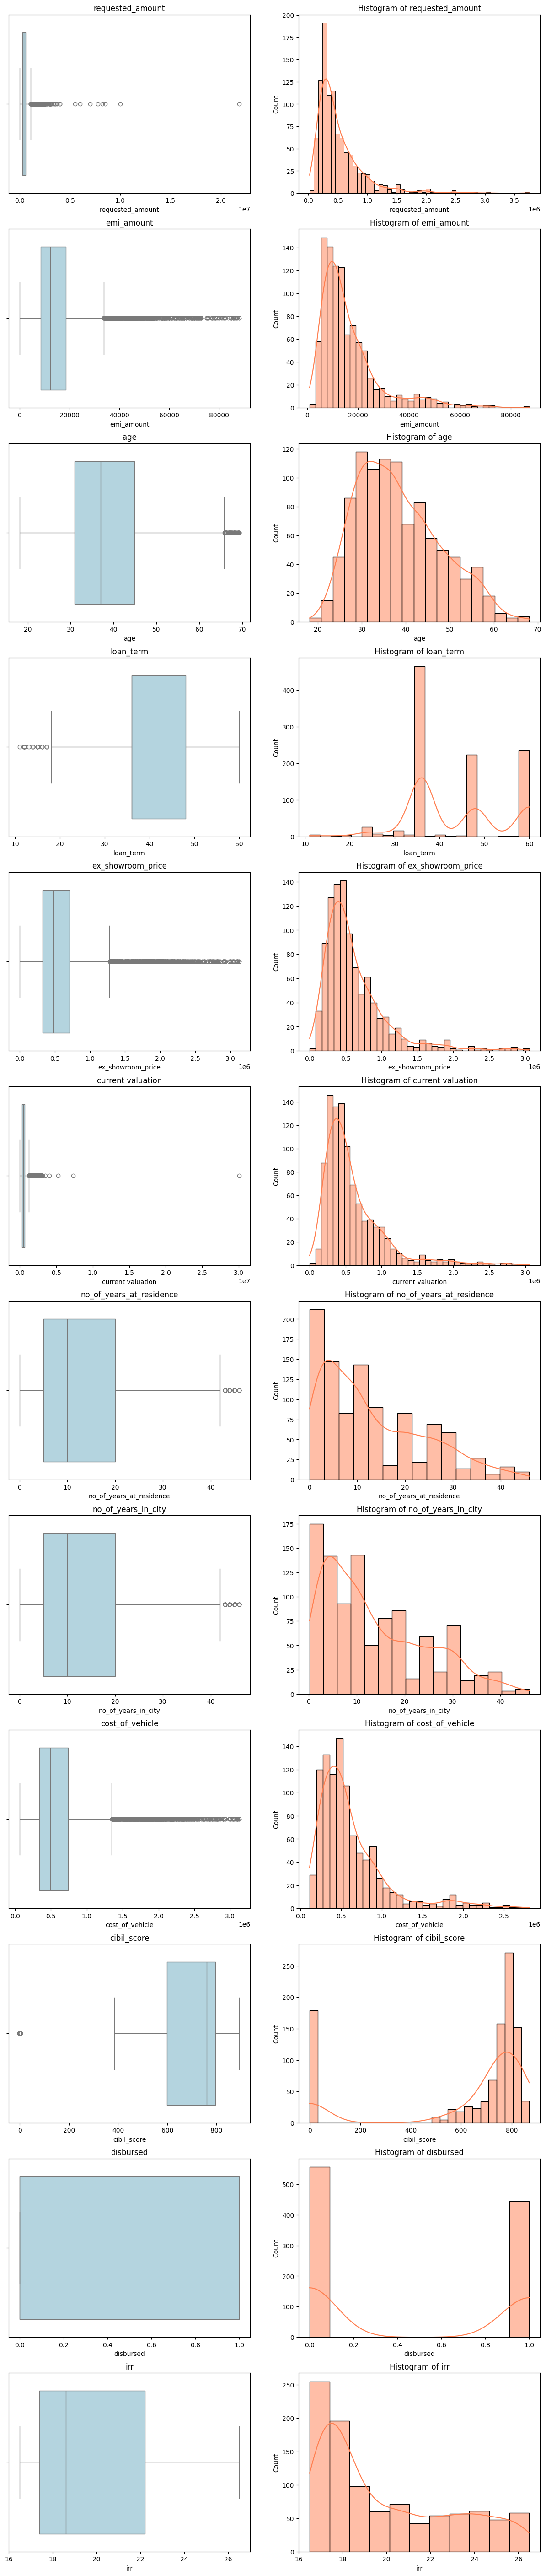

In [156]:
# Configurar el tamaño de la figura
plt.figure(figsize=(15, len(numeric_columns)*6))

for i, column in enumerate(numeric_columns, 1):
    print(column)
    # Crear subplots para box plot y histograma
    plt.subplot(len(numeric_columns), 2, 2*i-1)  # Box plot
    sns.boxplot(x=df_no_outliers_segment[column], color='lightblue')
    #kurt_value = kurtosis(df[column].dropna(), nan_policy='omit')
    plt.title(f"{column}")
    
    plt.subplot(len(numeric_columns), 2, 2*i)  # Histograma
    sns.histplot(df_no_outliers_segment[column].sample(1000), kde=True, color='coral')
    plt.title(f"Histogram of {column}")

In [157]:
# Calcular la curtosis para cada columna numérica
kurtosis_values = df_no_outliers_segment[numeric_columns].apply(lambda x: kurtosis(x, nan_policy='omit'))

# Crear un nuevo DataFrame con los valores de la curtosis
kurtosis_df = pd.DataFrame(kurtosis_values, columns=['Kurtosis'])

# Mostrar el DataFrame de curtosis
print(kurtosis_df)

                             Kurtosis
requested_amount           448.777861
emi_amount                   7.642140
age                         -0.195178
loan_term                   -0.877493
ex_showroom_price            7.729174
current valuation         1000.076055
no_of_years_at_residence    -0.168479
no_of_years_in_city         -0.219289
cost_of_vehicle              6.253534
cibil_score                 -0.103302
disbursed                   -1.957850
irr                         -0.727615


In [158]:
r = df_no_outliers_segment[numeric_columns].corr(method='spearman').round(3)
r

,requested_amount,emi_amount,age,loan_term,ex_showroom_price,current valuation,no_of_years_at_residence,no_of_years_in_city,cost_of_vehicle,cibil_score,disbursed,irr
requested_amount,1.000,0.897,0.109,0.273,0.837,0.832,-0.011,-0.013,0.814,0.096,-0.030,-0.023
emi_amount,0.897,1.000,0.137,-0.006,0.822,0.818,0.009,0.006,0.798,0.109,-0.012,-0.022
age,0.109,0.137,1.000,-0.058,0.067,0.066,0.087,0.085,0.057,0.182,0.036,-0.016
loan_term,0.273,-0.006,-0.058,1.000,0.246,0.245,-0.052,-0.051,0.237,-0.020,-0.061,-0.009
ex_showroom_price,0.837,0.822,0.067,0.246,1.000,0.984,0.023,0.021,0.962,0.038,-0.023,-0.025
current valuation,0.832,0.818,0.066,0.245,0.984,1.000,0.023,0.021,0.956,0.034,-0.022,-0.025
no_of_years_at_residence,-0.011,0.009,0.087,-0.052,0.023,0.023,1.000,0.980,0.016,0.006,0.000,-0.008
no_of_years_in_city,-0.013,0.006,0.085,-0.051,0.021,0.021,0.980,1.000,0.014,0.005,-0.002,-0.007
cost_of_vehicle,0.814,0.798,0.057,0.237,0.962,0.956,0.016,0.014,1.000,0.024,-0.019,-0.023
cibil_score,0.096,0.109,0.182,-0.020,0.038,0.034,0.006,0.005,0.024,1.000,0.077,-0.063


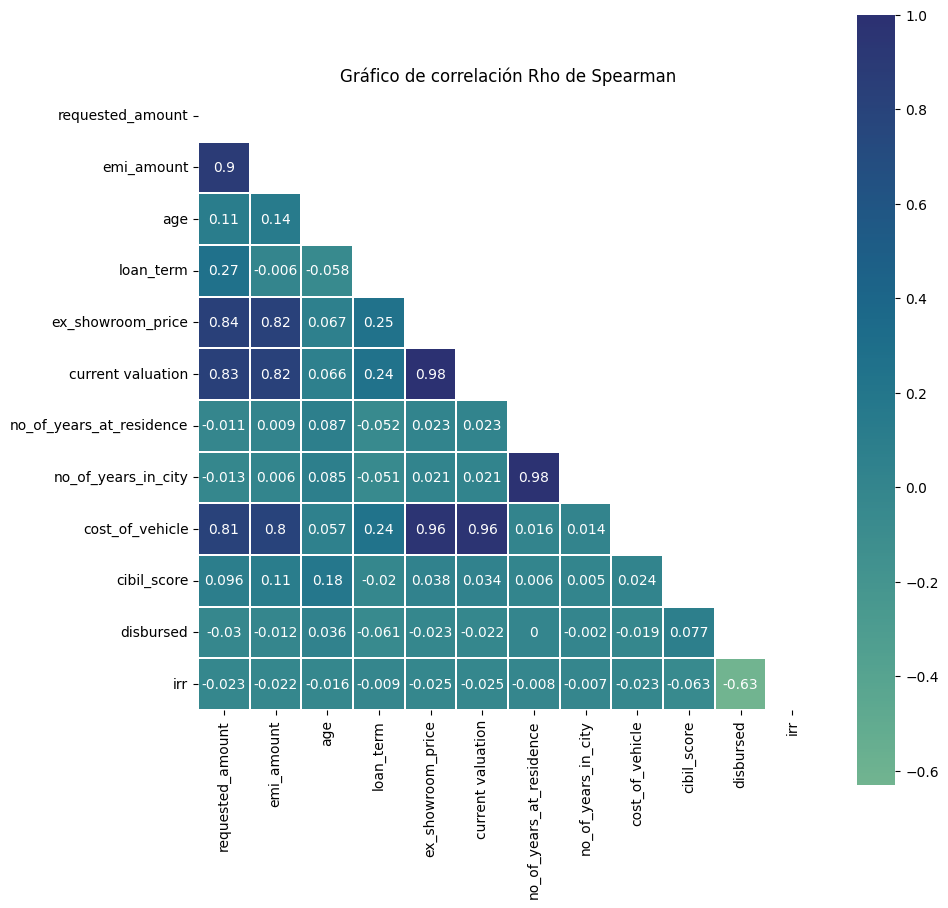

In [159]:
mask = np.triu(np.ones_like(r, dtype=bool )) #la máscara para el triángulo superior del gráfico
f, ax = plt.subplots(figsize = (10,10)) # la base para el gráfico
g = sns.heatmap(r, mask = mask, cmap='crest', vmax=1, center = 0,
            square = True, linewidths=.1, annot=True)

g.set_title("Gráfico de correlación Rho de Spearman");

## Categoricas

In [160]:
object_columns = df_no_outliers_segment.select_dtypes(include=['object']).columns

In [161]:
df_no_outliers.describe(include="object").T

,count,unique,top,freq
applicant_postal_code,17764,2692,132001.0,339
product_name1,17573,312,TOYOTA INNOVA,1331
product_line,17764,1322,TOYOTA INNOVA 2013 2.5 GX 7 STR BS-IV,402
variant_code,17764,1159,VDi,473
manufacturer_desc,17764,30,MARUTI,5169
marital_status_desc,17751,4,Married,16701
applicant_state_desc,17764,28,MAHARASHTRA,3536
applicant_city_desc,17764,343,HYDERABAD,1446
resid_owned_by_desc,17764,8,SELF,11596
employment_type_desc,17764,6,SELF EMPLOYED NON-PROFESSIONAL,12885


In [162]:
correlation_matrix = cramer_v_matrix(df_no_outliers_segment[object_columns])

In [163]:
correlation_matrix

,applicant_postal_code,product_name1,product_line,variant_code,manufacturer_desc,marital_status_desc,applicant_state_desc,applicant_city_desc,resid_owned_by_desc,employment_type_desc,segment,segment_desc,disbursed_categorical
applicant_postal_code,1.0,0.449531,0.451282,0.451352,0.429083,0.510719,0.984664,0.86975,0.479441,0.486983,0.437663,0.437663,0.471259
product_name1,0.449531,1.0,0.981935,0.954234,0.98523,0.135389,0.183083,0.165761,0.167586,0.19823,0.890231,0.890231,0.213779
product_line,0.451282,0.981935,1.0,0.97752,0.995291,0.267201,0.365983,0.330113,0.316988,0.335344,0.911316,0.911316,0.380496
variant_code,0.451352,0.954234,0.97752,1.0,0.975129,0.250905,0.369938,0.311526,0.297161,0.322519,0.878897,0.878897,0.361581
manufacturer_desc,0.429083,0.98523,0.995291,0.975129,1.0,0.052946,0.0734,0.149702,0.068168,0.104197,0.519292,0.519292,0.056956
marital_status_desc,0.510719,0.135389,0.267201,0.250905,0.052946,1.0,0.089404,0.172936,0.071732,0.078298,0.037207,0.037207,0.011034
applicant_state_desc,0.984664,0.183083,0.365983,0.369938,0.0734,0.089404,1.0,0.99488,0.15476,0.109081,0.076941,0.076941,0.140468
applicant_city_desc,0.86975,0.165761,0.330113,0.311526,0.149702,0.172936,0.99488,1.0,0.230737,0.222172,0.170174,0.170174,0.253209
resid_owned_by_desc,0.479441,0.167586,0.316988,0.297161,0.068168,0.071732,0.15476,0.230737,1.0,0.094958,0.034864,0.034864,0.022149
employment_type_desc,0.486983,0.19823,0.335344,0.322519,0.104197,0.078298,0.109081,0.222172,0.094958,1.0,0.093547,0.093547,0.026939


## Numéricas + Categóricas

In [164]:
df_yes_loan = df_no_outliers_segment[df_no_outliers_segment["disbursed"]==1].reset_index(drop=True)
df_group = df_yes_loan.groupby(["irr"]).agg("count")[["id"]].reset_index()
df_group = df_group.rename(columns={"id": "cantidad"})

<Axes: xlabel='irr', ylabel='cantidad'>

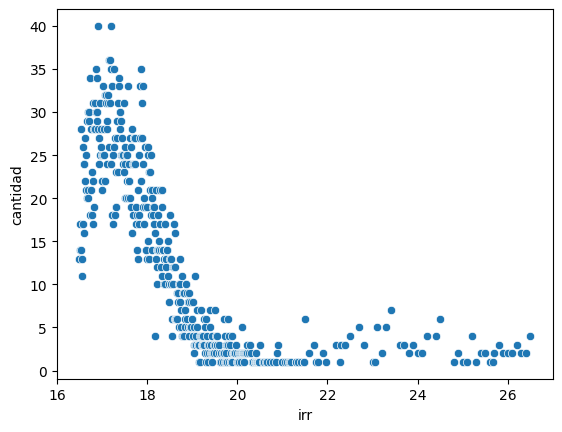

In [165]:
sns.scatterplot(data=df_group, x="irr", y="cantidad")

<Axes: ylabel='irr'>

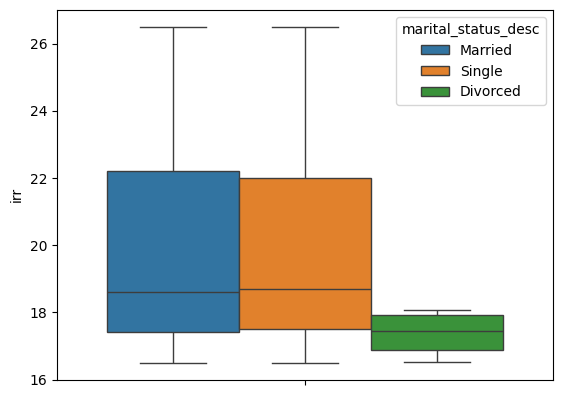

In [166]:
sns.boxplot(data=df_no_outliers_segment, hue="marital_status_desc", y="irr")

<Axes: ylabel='irr'>

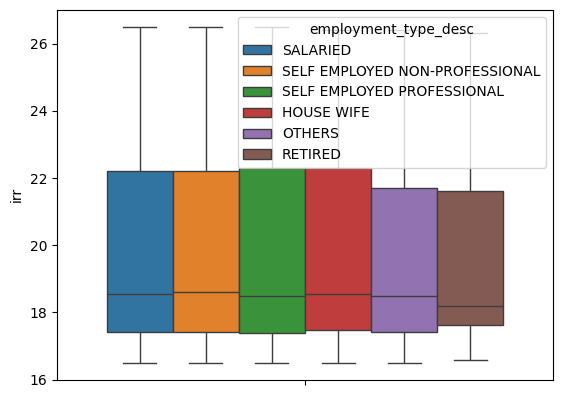

In [167]:
sns.boxplot(data=df_no_outliers_segment, hue="employment_type_desc", y="irr")

<Axes: ylabel='irr'>

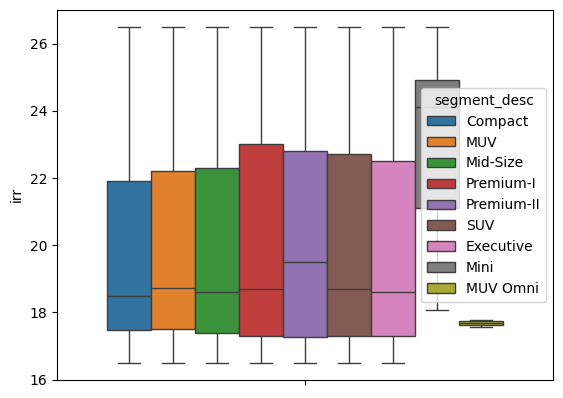

In [168]:
sns.boxplot(data=df_no_outliers_segment, hue="segment_desc", y="irr")

<Axes: ylabel='irr'>

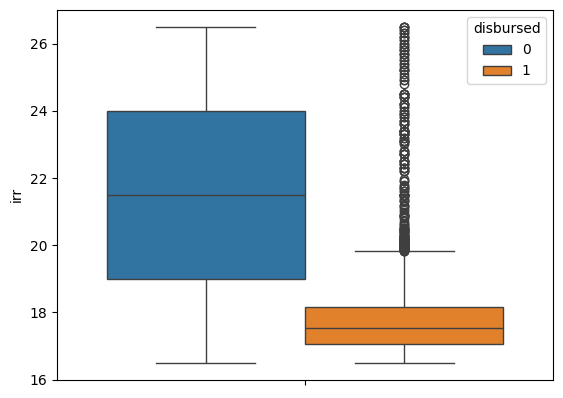

In [169]:
sns.boxplot(data=df_no_outliers_segment, hue="disbursed", y="irr")

<Axes: ylabel='irr'>

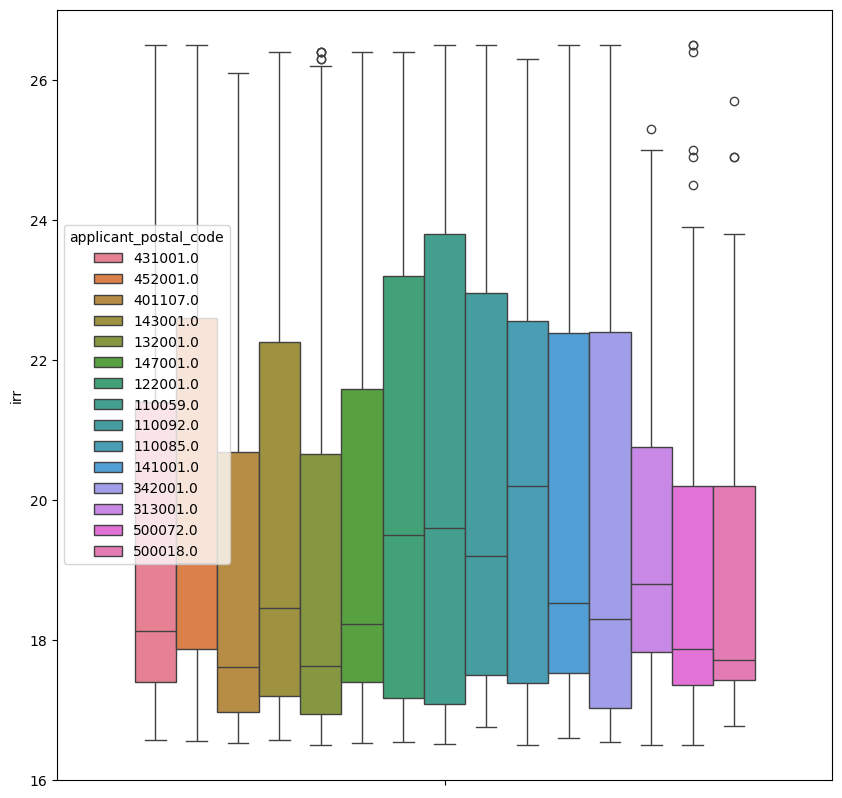

In [170]:
f, ax = plt.subplots(figsize = (10,10)) # la base para el gráfico
sns.boxplot(data=df_no_outliers_segment[df_no_outliers_segment["applicant_postal_code"].isin(df_no_outliers_segment["applicant_postal_code"].value_counts().head(15).index)], hue="applicant_postal_code", y="irr")

In [171]:
df_no_outliers_segment.to_pickle("../output/base_etapa_1.pkl")